# Imports

In [41]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

# Load Data

In [5]:
# Load the data
data = pd.read_excel("./Online Retail.xlsx", engine='openpyxl')

# Display the first few rows of the dataset
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Preprocess Data

In [6]:
# Remove duplicates
data.drop_duplicates(inplace=True)

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Feature Engineering
data['TotalSpent'] = data['Quantity'] * data['UnitPrice']
customer_data = data.groupby('CustomerID').agg({
    'TotalSpent': 'sum',
    'InvoiceNo': 'nunique',
    'InvoiceDate': ['min', 'max']
}).reset_index()

customer_data.columns = ['CustomerID', 'TotalSpent', 'NumberOfPurchases', 'FirstPurchaseDate', 'LastPurchaseDate']
customer_data['AveragePurchaseValue'] = customer_data['TotalSpent'] / customer_data['NumberOfPurchases']
customer_data['DaysBetweenPurchases'] = (customer_data['LastPurchaseDate'] - customer_data['FirstPurchaseDate']).dt.days / customer_data['NumberOfPurchases']

# Display the updated dataset
customer_data.head()

C:\Users\hassa\AppData\Local\Temp\ipykernel_18556\4294294893.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,CustomerID,TotalSpent,NumberOfPurchases,FirstPurchaseDate,LastPurchaseDate,AveragePurchaseValue,DaysBetweenPurchases
0,12346.0,0.00,2,2011-01-18 10:01:00,2011-01-18 10:17:00,0.000000,0.000000
1,12347.0,4310.00,7,2010-12-07 14:57:00,2011-12-07 15:52:00,615.714286,52.142857
2,12348.0,3366.27,5,2010-12-16 19:09:00,2011-09-25 13:13:00,673.254000,56.400000
3,12349.0,1757.55,1,2011-11-21 09:51:00,2011-11-21 09:51:00,1757.550000,0.000000
4,12350.0,334.40,1,2011-02-02 16:01:00,2011-02-02 16:01:00,334.400000,0.000000


# Modeling Clustering (Segmentation)

In [16]:
# Select features for clustering
features = customer_data[['AveragePurchaseValue', 'DaysBetweenPurchases', 'NumberOfPurchases']]

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(features)

# Display the clustered data
customer_data.head()


,CustomerID,TotalSpent,NumberOfPurchases,FirstPurchaseDate,LastPurchaseDate,AveragePurchaseValue,DaysBetweenPurchases,Cluster
0,12346.0,0.00,2,2011-01-18 10:01:00,2011-01-18 10:17:00,0.000000,0.000000,0
1,12347.0,4310.00,7,2010-12-07 14:57:00,2011-12-07 15:52:00,615.714286,52.142857,2
2,12348.0,3366.27,5,2010-12-16 19:09:00,2011-09-25 13:13:00,673.254000,56.400000,2
3,12349.0,1757.55,1,2011-11-21 09:51:00,2011-11-21 09:51:00,1757.550000,0.000000,4
4,12350.0,334.40,1,2011-02-02 16:01:00,2011-02-02 16:01:00,334.400000,0.000000,2


# Visualize Clusters 

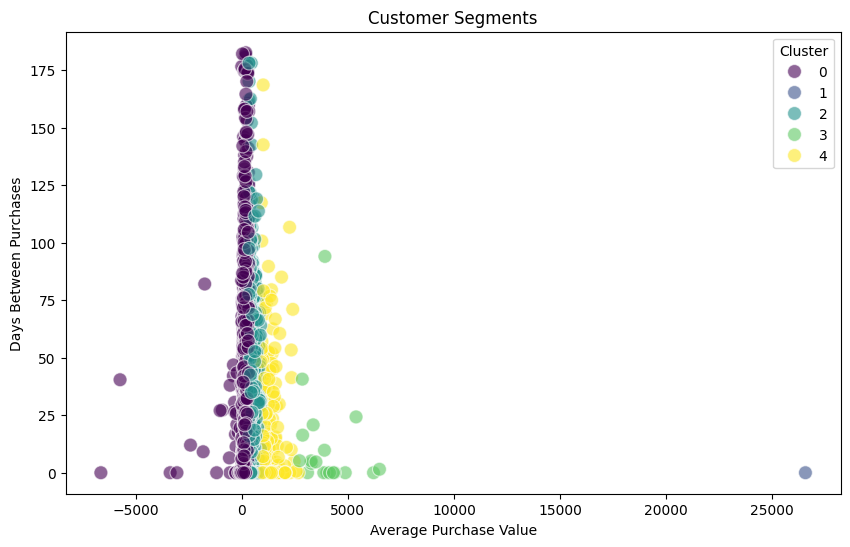

In [17]:
# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AveragePurchaseValue', y='DaysBetweenPurchases', hue='Cluster', data=customer_data, palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('Customer Segments')
plt.xlabel('Average Purchase Value')
plt.ylabel('Days Between Purchases')
plt.legend(title='Cluster')
plt.show()

# Modeling Colaborative Filtering (Personalized Recommendation)

In [58]:
# Convert CustomerID to integers
data['CustomerID'] = data['CustomerID'].astype(int)

# Create a pivot table
pivot_table = data.pivot_table(index='CustomerID', columns='StockCode', values='Quantity').fillna(0)

# Convert column names to strings
pivot_table.columns = pivot_table.columns.astype(str)
# Fit the model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(pivot_table)

NearestNeighbors(algorithm='brute', metric='cosine')

In [60]:
# Function to recommend products
def recommend_products(customer_id, n_recommendations=5):
    customer_id = int(customer_id)
    if customer_id not in pivot_table.index:
        return f"Customer ID {customer_id} not found in the dataset."
    
    distances, indices = model.kneighbors(pivot_table.loc[customer_id].values.reshape(1, -1), n_neighbors=n_recommendations+1)
    
    # Get the customer IDs of the nearest neighbors
    neighbor_ids = pivot_table.index[indices.flatten()].tolist()
    
    # Get the products purchased by the neighbors
    neighbor_purchases = data[data['CustomerID'].isin(neighbor_ids)]
    
    # Recommend the most frequently purchased products by the neighbors
    recommendations = neighbor_purchases['StockCode'].value_counts().head(n_recommendations).index.tolist()
    
    # Get the descriptions for the recommended products
    recommended_products = data[data['StockCode'].isin(recommendations)][['StockCode', 'Description']].drop_duplicates()
        # Convert to list of tuples
    recommended_products_list = list(recommended_products.itertuples(index=False, name=None))
    
    return recommended_products_list

In [72]:
def recommend_products_with_clustering(customer_id, n_recommendations=5):
    customer_id = int(customer_id)
    if customer_id not in pivot_table.index:
        return f"Customer ID {customer_id} not found in the dataset."
    
    # Find the cluster of the customer
    customer_cluster = customer_data.loc[customer_data['CustomerID'] == customer_id, 'Cluster'].values[0]
    
    # Filter data to include only customers in the same cluster
    cluster_customers = customer_data[customer_data['Cluster'] == customer_cluster]['CustomerID'].tolist()
    cluster_data = pivot_table[pivot_table.index.isin(cluster_customers)]
    
    # Fit the model on the filtered cluster data
    model.fit(cluster_data)
    
    distances, indices = model.kneighbors(pivot_table.loc[customer_id].values.reshape(1, -1), n_neighbors=n_recommendations+1)
    
    # Get the customer IDs of the nearest neighbors
    neighbor_ids = cluster_data.index[indices.flatten()].tolist()
    
    # Get the products purchased by the neighbors
    neighbor_purchases = data[data['CustomerID'].isin(neighbor_ids)]
    
    # Recommend the most frequently purchased products by the neighbors
    recommendations = neighbor_purchases['StockCode'].value_counts().head(n_recommendations).index.tolist()
    
    # Get the descriptions for the recommended products
    recommended_products = data[data['StockCode'].isin(recommendations)][['StockCode', 'Description']].drop_duplicates()
    
    # Convert to list of tuples
    recommended_products_list = list(recommended_products.itertuples(index=False, name=None))
    
    return recommended_products_list

In [73]:
# Gradio interface
def gradio_recommend(customer_id, n_recommendations, rec_type):
    print(customer_id, n_recommendations, rec_type)
    if rec_type:
        recommendations = recommend_products_with_clustering(customer_id, n_recommendations)
    else:
        recommendations = recommend_products(customer_id, n_recommendations)
        
    return recommendations

# Create Gradio app
iface = gr.Interface(
    fn=gradio_recommend,
    inputs=[
        gr.Textbox(label="Customer ID"),
        gr.Slider(minimum=1, maximum=10, value=5, step=1, label="Number of Recommendations"),
        gr.Checkbox(value=True, label="Use Clustering?")
    ],
    outputs=gr.Dataframe(headers=["StockCode", "Description"]),
    title="Product Recommendations",
    description="Enter a Customer ID and the number of recommendations to get product recommendations based on purchasing behavior."
)
# Launch the app
iface.launch()

* Running on local URL:  http://127.0.0.1:7872

To create a public link, set `share=True` in `launch()`.


12347 5 True


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 5 False


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 5 True


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 5 True


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 5 False


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 5 True


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 5 False


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 10 True


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 10 False


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 10 False


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


12347 10 True


C:\Users\hassa\anaconda3\envs\sem3_DAIS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
